In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy
from scipy.fft import fft, rfft, fftshift,rfft2, fftfreq, rfftfreq
import jax
from scipy.special import jv
from matplotlib.image import NonUniformImage
import sncosmo

In [2]:
wavegrid = numpy.load("WaveGrid.npy")
flux = numpy.load("Phase0Flux.npy")
flux=flux/1e39
flux_int= flux.sum(axis=(1,2))

(3000.0, 10000.0)

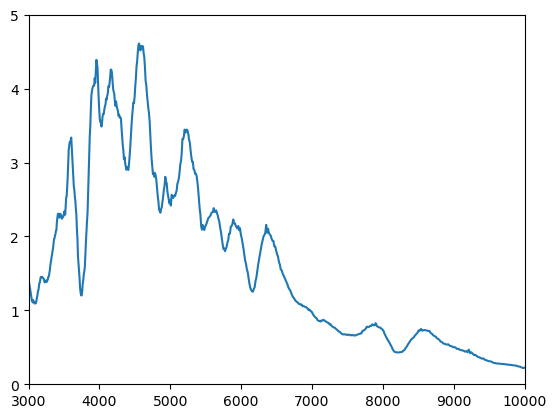

In [3]:
plt.plot(wavegrid, flux_int)
plt.ylim((0,5))
plt.xlim((3000,10000))

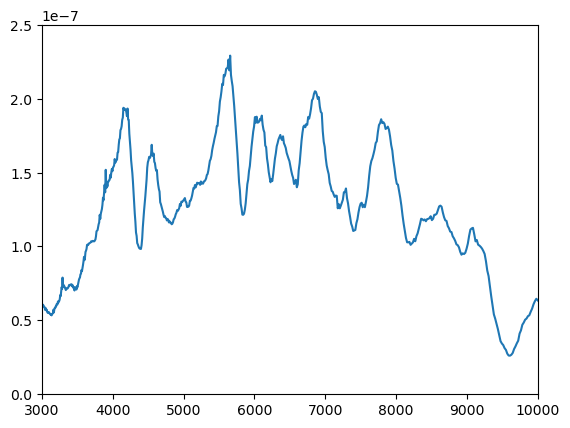

In [21]:
lambdas = numpy.flip(wavegrid)
spectrum = sncosmo.Spectrum(lambdas, numpy.flip(flux_int))
spectrum_mag = spectrum.bandmag('bessellb', magsys='vega')
flux_int = flux_int * 10**((spectrum_mag-12)/2.5) # now in units of  (erg / s / cm^2 / A) for B=12 mag
# want  dΓ/dν = AFv/(hν0).
# 
# spectrum = sncosmo.Spectrum(lambdas, flux_int) # now in units of  (erg / s / cm^2 / A) for B=12 mag
Area = 88 * 100 * 100. # cm^2
h = 6.626* 10**(-34+7)  # erg s
c = 3e10 # cm/s
lcm = wavegrid/1e8  # cm
dGammadnu = Area * flux_int * wavegrid  / h /c/c*lcm*lcm
plt.plot(lambdas,dGammadnu)
plt.ylim((0,2.5e-7))
plt.xlim((3000,10000))
sigma_t =13*10**-12

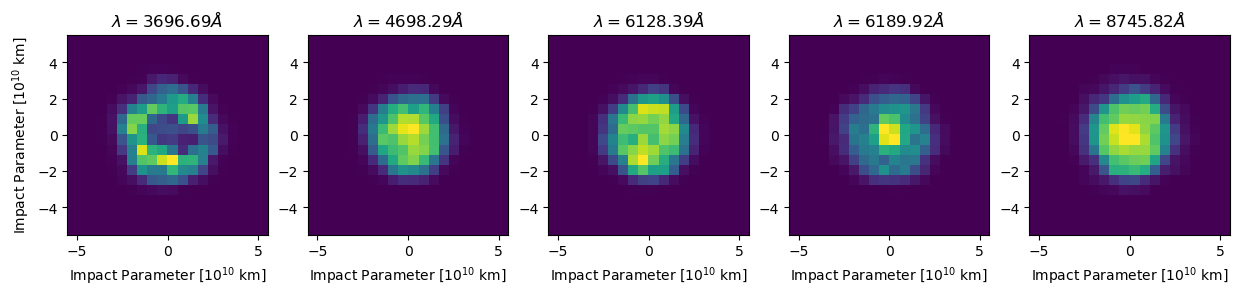

In [44]:
wls = [5850,6055,6128,6189,6355.12]
# wls = [3700, 4700, 6055, 6355,8750]
wls = [3700, 4700, 6128, 6189,8750]
idxs = [ numpy.abs(wavegrid - l).argmin() for l in wls]
fig,axs = plt.subplots(1,5, figsize=(15, 3))
for i, idx in enumerate(idxs):
    axs[i].imshow(flux[idx,:,:],extent=[-32000*3600*24*20/1e10, 32000*3600*24*20/1e10,-32000*3600*24*20/1e10, 32000*3600*24*20/1e10])
    axs[i].set_title(r'$\lambda={:.2f}\AA$'.format(wavegrid[idx]))
    axs[i].set_xlabel(r"Impact Parameter [$10^{10}~\text{km}$]")
    if i==0:
        axs[i].set_ylabel(r"Impact Parameter [$10^{10}~\text{km}$]")
plt.savefig('image.pdf')

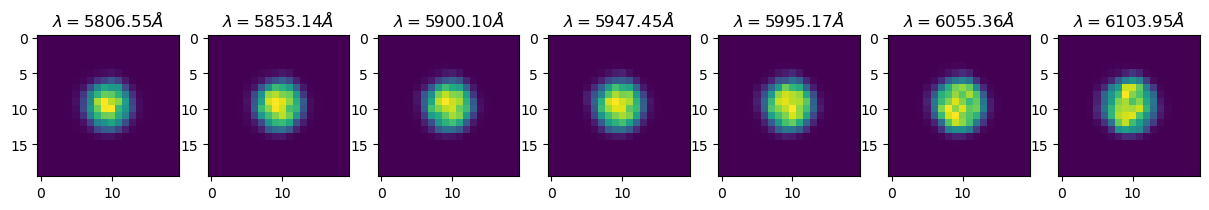

In [65]:
fig,axs = plt.subplots(1,7, figsize=(15, 3))

wls = numpy.linspace(5800,6100,7)
idxs = [ numpy.abs(wavegrid - l).argmin() for l in wls]
for i, idx in enumerate(idxs):
    axs[i].imshow(flux[idx,:,:])
    axs[i].set_title(r'$\lambda={:.2f}\AA$'.format(wavegrid[idx]))
# plt.savefig('image.pdf')

/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_25004/684002343.py:39: RuntimeWarning: invalid value encountered in divide
  airy = (2*jv(1,x_airy)/x_airy)**2


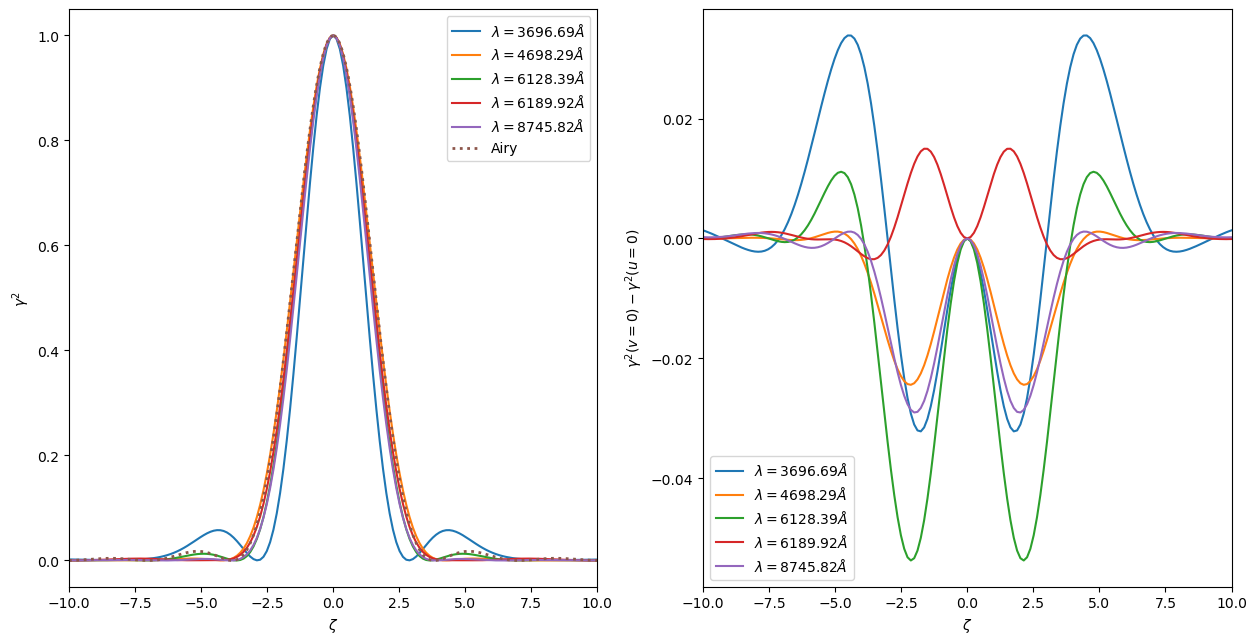

In [45]:
factor = 10
fluxshape = flux[0,:,:].shape
paddedarray = numpy.zeros((fluxshape[0]*factor, fluxshape[1]*factor))
# fig,axs = plt.subplots(1,5, figsize=(15, 3))
fig,axs = plt.subplots(1,2, figsize=(15, 7.5))
wls = [3700, 4700, 6128, 6189,8750]
idxs = [ numpy.abs(wavegrid - l).argmin() for l in wls]
for i, idx in enumerate(idxs):
    flux_norm = flux[idx,:,:]
    flux_norm = flux_norm/flux_norm.sum()
    paddedarray[0:fluxshape[0], 0:fluxshape[1]]= flux_norm
    # print(flux_norm)
    # axs[i].imshow(paddedarray)
    gamma = jax.numpy.fft.fft2(paddedarray)
    # gamma = jax.numpy.fft.rfft2(flux[idx,:,:])

    gamma = jax.numpy.absolute(gamma)
    gamma2 = gamma*gamma
    gamma2_shift = numpy.fft.fftshift(gamma2)
    x = numpy.arange(gamma2.shape[0])-gamma2.shape[0]//2
    # axs.plot(x*numpy.pi/25,gamma2_shift[gamma2.shape[0]//2,:]) #,label=r'$u=0$')
    axs[0].plot(x*numpy.pi/25, gamma2_shift[:,gamma2.shape[0]//2],label=r'$\lambda={:.2f}\AA$'.format(wavegrid[idx]))
    axs[1].plot(x*numpy.pi/25, gamma2_shift[:,gamma2.shape[0]//2] - gamma2_shift[gamma2.shape[0]//2,:],label=r'$\lambda={:.2f}\AA$'.format(wavegrid[idx]))
# axs.set_title(r'$\lambda={:.2f}\AA$'.format(wavegrid[idx]))

    # axs[i].plot(x*numpy.pi/25,gamma2_shift[gamma2.shape[0]//2,:],label=r'$u=0$')
    # axs[i].plot(x*numpy.pi/25, gamma2_shift[:,gamma2.shape[0]//2],label=r'$v=0$')
    # axs[i].set_xlim((-10,10))
    # axs[i].set_title(r'$\lambda={:.2f}\AA$'.format(wavegrid[idx]))
    # x_airy = numpy.linspace(-10.,10.,1001)
    # airy = (2*jv(1,x_airy)/x_airy)**2
    # axs[i].plot(x_airy,airy,label='Airy',ls='dotted',lw=2)
    # axs[i].legend()
    # print(gamma)
    # axs[i].imshow()
    # axs[i].imshow(gamma[0:fluxshape[0], 0:fluxshape[1]])
    # wef
x_airy = numpy.linspace(-10.0,10.,1001)
airy = (2*jv(1,x_airy)/x_airy)**2
axs[0].plot(x_airy,airy,label='Airy',ls='dotted',lw=2)
axs[0].set_xlim((-10,10))
axs[0].set_xlabel(r"$\zeta$")
axs[0].set_ylabel(r"$\gamma^2$")
axs[0].legend()
axs[1].set_xlim((-10,10))
axs[1].legend()
axs[1].set_xlabel(r"$\zeta$")
axs[1].set_ylabel(r"$\gamma^2(v=0)-\gamma^2(u=0)$")
plt.savefig('gamma2_sedona.pdf')

/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_25004/2209627229.py:62: RuntimeWarning: divide by zero encountered in divide
  pos = axs[i].imshow((1/F00)[minx:maxx,minx:maxx] ,norm='log',vmax=10)
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_25004/2209627229.py:65: RuntimeWarning: divide by zero encountered in divide
  pos2 = axs2[i].imshow((1/F11)[minx:maxx,minx:maxx],norm='log',vmax=10)
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_25004/2209627229.py:69: RuntimeWarning: divide by zero encountered in divide
  numpy.sqrt(1/Fsinv[minx:maxx,minx:maxx]),norm='log',vmin=0.01,vmax=1)
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_25004/2209627229.py:69: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(1/Fsinv[minx:maxx,minx:maxx]),norm='log',vmin=0.01,vmax=1)
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_25004/2209627229.py:62: RuntimeWarning: divide by zero encountered in divide
  pos = axs[i].imshow((1/F00)[minx

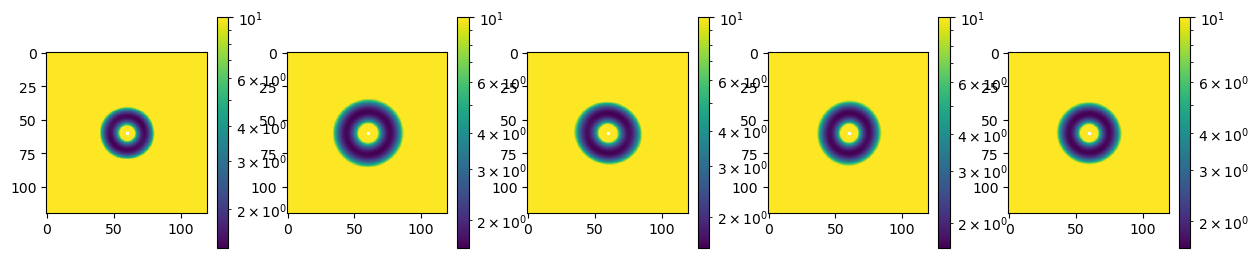

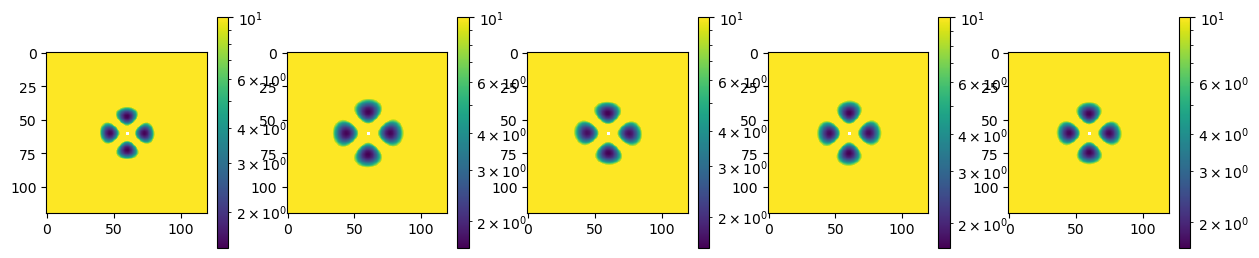

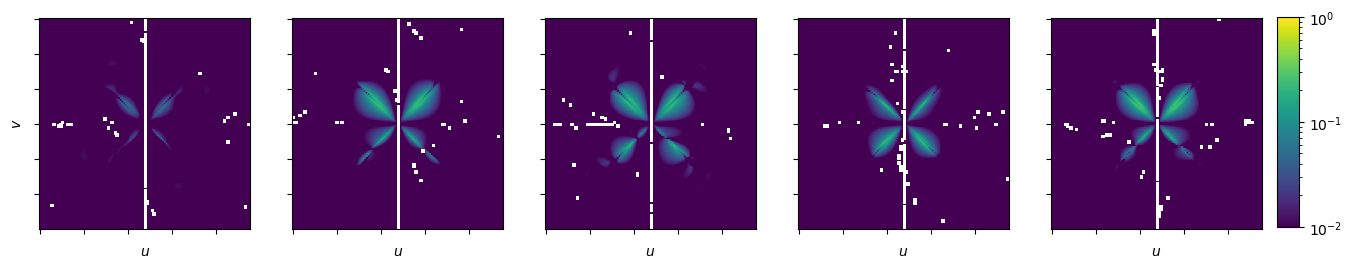

NameError: name 'wef' is not defined

In [46]:
wls = [5850,6055,6128,6189,6355.12]
wls = [3700, 4700, 6055, 6355,8750]
wls = [3700, 4700, 6128, 6189,8750]

idxs = [ numpy.abs(wavegrid - l).argmin() for l in wls]
factor = 10

fluxshape = flux[0,:,:].shape
paddedarray = numpy.zeros((fluxshape[0]*factor, fluxshape[1]*factor))
fig,axs = plt.subplots(1,5, figsize=(15, 3))
fig2,axs2 = plt.subplots(1,5, figsize=(15, 3))
fig3,axs3 = plt.subplots(1,5, figsize=(15, 3))
# fig4,axs4 = plt.subplots(1,5, figsize=(15, 3))
# fig,axs = plt.subplots(1,2, figsize=(15, 7.5))

# theta = numpy.arange(fluxshape[0]*factor)
theta  = [i- fluxshape[0]/2 + 0.5 for i in range(paddedarray.shape[0])]
theta = numpy.array(theta)

Fsinv = numpy.zeros((paddedarray.shape[0],paddedarray.shape[1]))
# Fsinv_phi = numpy.zeros((paddedarray.shape[0],paddedarray.shape[1]))
# Fsinv_s = numpy.zeros((paddedarray.shape[0],paddedarray.shape[1]))
for i, idx in enumerate(idxs):
    Fsinv[:]=0
    flux_norm = flux[idx,:,:]
    flux_norm = flux_norm/flux_norm.sum()
    paddedarray[0:fluxshape[0], 0:fluxshape[1]]= flux_norm
    
    gamma = jax.numpy.fft.fft2(paddedarray)
    dgammau = -2j*numpy.pi* jax.numpy.fft.fft2(paddedarray*theta[:,None])
    dgammav = -2j*numpy.pi* jax.numpy.fft.fft2(paddedarray*theta[None,:])

    u=fftfreq(paddedarray.shape[0])
    v=fftfreq(paddedarray.shape[1])
    
    dgammas = -(u[:,None]*dgammau + v[None,:]*dgammav)
    dgammaphi = (u[:,None]*dgammau - v[None,:]*dgammav)

    F00= jax.numpy.absolute(2*gamma.conjugate() * dgammas) **2
    F01= jax.numpy.absolute(2*gamma.conjugate() * dgammas)*jax.numpy.absolute(2*gamma.conjugate() * dgammaphi)
    F11 = jax.numpy.absolute(2*gamma.conjugate() * dgammaphi)**2

    F00 = numpy.fft.fftshift(F00)
    F01 = numpy.fft.fftshift(F01)
    F11 = numpy.fft.fftshift(F11)    

    F00rot=numpy.rot90(F00)
    F01rot=numpy.rot90(F01)
    F11rot=numpy.rot90(F11)    
    for ui in range(0,Fsinv.shape[0]):
        for vi in range(0,Fsinv.shape[1]):
            if ui==0 and vi==0:
                continue
            try:
                Fsinv[ui,vi] = numpy.linalg.inv([[F00[ui,vi]+F00rot[ui,vi],F01[ui,vi]+F01rot[ui,vi]],[F01[ui,vi]+F01rot[ui,vi],F11[ui,vi]+F11rot[ui,vi]]])[0,0]
            except:
                pass
    minx = paddedarray.shape[0]//2-factor//3*fluxshape[0]
    maxx = paddedarray.shape[0]//2+factor//3*fluxshape[0]
    # pos = axs[i].imshow(numpy.fft.fftshift(Fsinv)[minx:maxx,minx:maxx] ,norm='log',vmax=100)
    # pos = axs[i].imshow(numpy.fft.fftshift(Fsinv),vmin=0,vmax=10)
    pos = axs[i].imshow((1/F00)[minx:maxx,minx:maxx] ,norm='log',vmax=10)    
    fig.colorbar(pos)
    
    pos2 = axs2[i].imshow((1/F11)[minx:maxx,minx:maxx],norm='log',vmax=10)
    fig2.colorbar(pos2)
    # print(Fsinv.min(),Fsinv.max())
    im = axs3[i].imshow(dGammadnu[idx] * (128*numpy.pi)**(-0.25) * numpy.sqrt(3600/2/sigma_t) *
                        numpy.sqrt(1/Fsinv[minx:maxx,minx:maxx]),norm='log',vmin=0.01,vmax=1)
    if i ==0:
        axs3[i].set_ylabel(r'$v$')
    axs3[i].set_xlabel(r'$u$')
    axs3[i].xaxis.set_ticklabels([])
    axs3[i].yaxis.set_ticklabels([])
fig3.subplots_adjust(right=0.94)
cbar_ax = fig3.add_axes([0.95, 0.15, 0.015, 0.7])
fig3.colorbar(im, cax=cbar_ax)


plt.show()
wef

plt.savefig('gamma2_sedona.pdf')

In [99]:
def dft_polar(y, norder=None):
    ny = len(y)
    if norder is None:
        norder = ny
    rhos = numpy.arange(norder)/ny
    ans = numpy.zeros(norder)
    theta = numpy.arange(ny)
    for i, rho in enumerate(rhos):
        integrand = y*jv(0,2*numpy.pi*rho*theta)*theta
        ans[i]=numpy.trapezoid(integrand)
    return 2*numpy.pi*ans

def dft_polar_der(y, norder=None):
    ny = len(y)
    if norder is None:
        norder = ny
    rhos = numpy.arange(norder)/ny
    ans = numpy.zeros(norder)
    theta = numpy.arange(ny)
    for i, rho in enumerate(rhos):
        integrand = y*jv(1,2*numpy.pi*rho*theta)*theta**2
        ans[i]=numpy.trapezoid(integrand)
    return -(2*numpy.pi)**2*ans

# for s=1
def dgamma2ds(y,norder=None):
    ny = len(y)
    if norder is None:
        norder = ny
    rhos = numpy.arange(norder)/ny
    gamma = dft_polar(y, norder=norder)
    return - 2* gamma * rhos *dft_polar_der(y, norder=norder)

def dgamma2dsi(y, u, vs, norder=None):
    ny = len(y)
    if norder is None:
        norder = ny
    rhos = numpy.arange(norder)/ny
    gamma = dft_polar(y, norder=norder)
    dgammadrho = dft_polar_der(y, norder=norder)
    dum = numpy.sqrt(u**2  + vs**2)
    return 2* numpy.interp(dum, rhos, gamma) * u/dum * numpy.interp(dum, rhos, dgammadrho)

(0.0, 10.0)

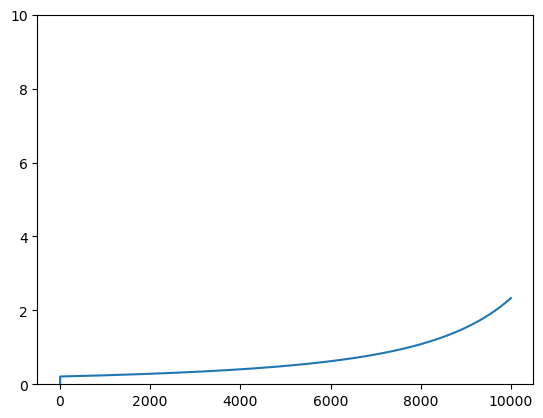

In [9]:
plt.plot(lambdas-numpy.roll(lambdas,1))
plt.ylim((0,10))

/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_57731/4241469245.py:17: RuntimeWarning: invalid value encountered in divide
  plt.plot(x,(2*jv(1,x)/x)**2,label='Airy')
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_57731/4241469245.py:18: RuntimeWarning: invalid value encountered in divide
  plt.plot(x,2*(2*jv(1,x)/x)*(jv(0,x)-jv(2,x)-2*jv(1,x)/x),label='dAirydtheta')


(0.0, 10.0)

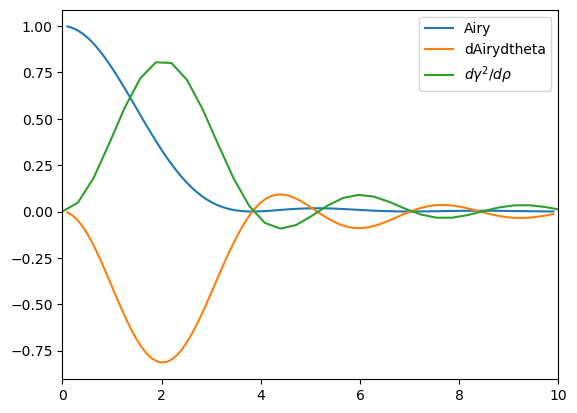

In [4]:
norder = 200
ncirc = 100
factor =20
flux = numpy.zeros(ncirc*factor)
flux[:ncirc]=1
gamma = dft_polar(flux,norder=norder)
gamma20=gamma[0]**2
gamma=gamma/gamma[0]
gamma2 = gamma*gamma
x = numpy.arange(0,10,0.1)
# plt.plot(numpy.arange(len(gamma2))*2*numpy.pi/10,gamma,label=r'$\gamma$')
# plt.plot(x,(2*jv(1,x)/x),label='sqrt Airy')
# plt.plot(numpy.arange(len(gamma2))*2*numpy.pi/10,20*dft_polar_der(flux, norder=norder)/gamma20,label=r'$d\gamma/d\rho$')
# plt.plot((0,12),(0,0))

# plt.plot(numpy.arange(len(gamma2))*2*numpy.pi/10,gamma2,label=r'$\gamma^2$')
plt.plot(x,(2*jv(1,x)/x)**2,label='Airy')
plt.plot(x,2*(2*jv(1,x)/x)*(jv(0,x)-jv(2,x)-2*jv(1,x)/x),label='dAirydtheta')
plt.plot(numpy.arange(len(gamma2))*2*numpy.pi/factor,dgamma2ds(flux, norder=norder)/gamma20,label=r'$d\gamma^2/d\rho$')
# plt.plot((0,12),(0,0))
# plt.ylim((0,10))

# plt.plot(numpy.arange(len(gamma2))*2*numpy.pi/10,numpy.abs(dgamma2ds(flux,norder=norder))/gamma20)

plt.legend()
plt.xlim((0,10))

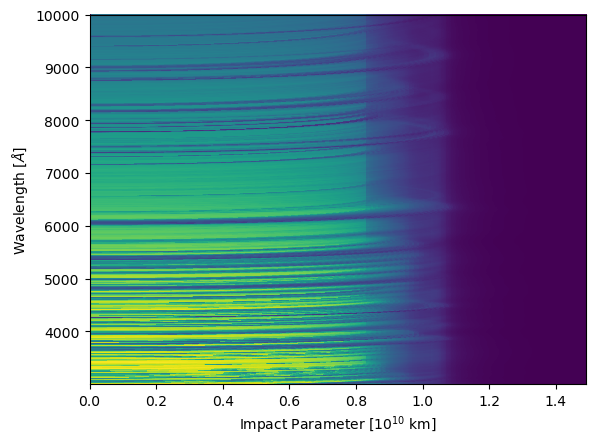

In [5]:
interp = 'nearest'
fig, ax = plt.subplots()
im = NonUniformImage(ax, interpolation=interp, extent=(axis0[0]/1e15,axis0[-1]/1e15,axis1[-1],axis1[0]))
im.set_data(axis0[:]/1e15, lambdas, numpy.flip(block0_values[:,:],axis=0))
ax.add_image(im)
ax.set_xlim(axis0[0]/1e15, axis0[-1]/1e15)
ax.set_ylim(axis1[-1],axis1[0])
ax.set_ylabel(r"Wavelength [$\AA$]")
ax.set_xlabel(r"Impact Parameter [$10^{10}~\text{km}$]")
plt.savefig("sn2001fe.pdf")

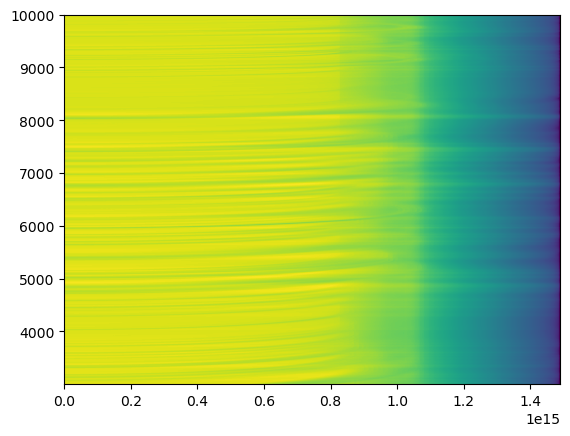

In [6]:
ren = block0_values[:]
ren = ren/ren.sum(axis=1)[:,None]
plt.imshow(ren,extent=[axis0[0],axis0[-1],lambdas[0],lambdas[-1]],aspect='auto',norm='log')

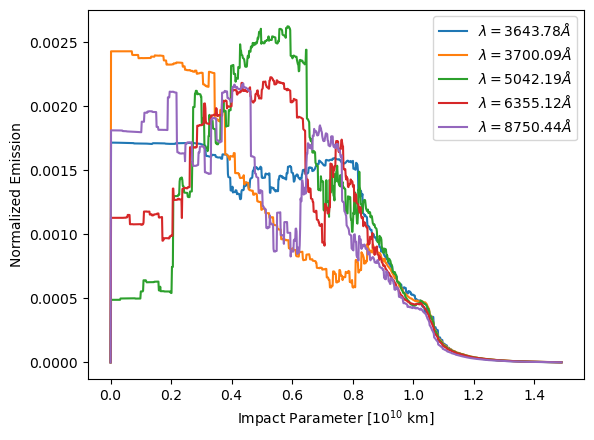

In [7]:
plt.plot(axis0[:]/1e15, ren[maxorder[0],:],label=r"$\lambda={:.2f}\AA$".format(lambdas[maxorder[0]]))
plt.plot(axis0[:]/1e15, ren[idx3700,:],label=r"$\lambda={:.2f}\AA$".format(lambdas[idx3700]))
plt.plot(axis0[:]/1e15, ren[maxorder[-1],:],label=r"$\lambda={:.2f}\AA$".format(lambdas[maxorder[-1]]))
plt.plot(axis0[:]/1e15, ren[idx6355,:],label=r"$\lambda={:.2f}\AA$".format(lambdas[idx6355]))
plt.plot(axis0[:]/1e15, ren[idx8750,:],label=r"$\lambda={:.2f}\AA$".format(lambdas[idx8750]))
plt.xlabel(r"Impact Parameter [$10^{10}~\text{km}$]")
plt.ylabel(r"Normalized Emission")
plt.legend()
plt.savefig('impact.pdf')

In [8]:
def gamma2snr():
    nd = axis0[:].shape[0]
    delta = axis0[1]-axis0[0]
    drad = 0.475e15
    ndisk = int(2*drad/delta)
    factor=40
    norder = factor * 5
    
    # nexpand = int(factor*ndisk)
    flux = numpy.zeros(nd*factor)
    fig, ax = plt.subplots()
    fig2, ax2 = plt.subplots()  
    for index in [maxorder[0],idx3700,maxorder[-1],idx6355,idx8750]:
        flux[:]=0
        flux[:nd] = block0_values[index,:]
        # flux[:ndisk] = 1
        gamma = dft_polar(flux,norder=norder)
        gamma0 = gamma[0]
        gamma=gamma/gamma[0]
        gamma2 = gamma*gamma
        ax.plot(numpy.arange(gamma2.shape[0])*2*numpy.pi/(nd*factor/ndisk),gamma2,label=r"$\lambda={:.2f}\AA$".format(lambdas[index]))
    
        fm = dgamma2ds(flux, norder=norder)/gamma0**2
        fm= numpy.abs(fm)
        ax2.plot(numpy.arange(fm.shape[0])*2*numpy.pi/(nd*factor/ndisk),fm,label=r"$\lambda={:.2f}\AA$".format(lambdas[index]))
    
    zeta = numpy.arange(0,nd,0.01)
    airy = (2*jv(1,zeta)/zeta)**2
    ax.plot(zeta,airy,label='Airy',ls='dotted',lw=2)
    ax.set_ylabel(r"$|\gamma|^2$")
    ax.set_xlabel(r"$\zeta$")
    ax.set_xlim((0,10))
    ax.legend()
    fig.savefig('gamma2.pdf')
    dairy = (2*(2*jv(1,zeta)/zeta)*(jv(0,zeta)-jv(2,zeta)-2*jv(1,zeta)/zeta))
    ax2.plot(zeta,numpy.abs(dairy),label='Airy',ls='dotted')
    ax2.set_ylabel(r"$\text{SNR}_s$")
    ax2.set_xlabel(r"$\zeta$")
    ax2.set_xlim((0,10))
    # ax2.set_ylim((0,1))
    ax2.legend()
    fig2.savefig('snr.pdf')

# gamma2snr()

In [9]:
def bias():
    nd = axis0[:].shape[0]
    delta = axis0[1]-axis0[0]
    drad = 0.475e15
    ndisk = int(2*drad/delta)
    factor=40
    norder = factor * 5
    
    # nexpand = int(factor*ndisk)
    flux = numpy.zeros(nd*factor)
    fig, ax = plt.subplots()
    index = idx6355 #maxorder[0]
    flux[:]=0
    flux[:nd] = block0_values[index,:]
    gamma = dft_polar(flux,norder=norder)
    gamma0 = gamma[0]
    gamma = gamma/gamma0
    gamma2fid = gamma*gamma
    
    # for index in [maxorder[0],idx3700,maxorder[-1],idx6355,idx8750]:
    for index in [maxorder[0],idx3700,maxorder[-1],idx8750]:
        flux[:]=0
        flux[:nd] = block0_values[index,:]
        gamma = dft_polar(flux,norder=norder)
        gamma0 = gamma[0]
        gamma = gamma/gamma0
        gamma2 = gamma * gamma
        _ = dgamma2ds(flux, norder=norder)/gamma0**2
        D = gamma2-gamma2fid
        ax.plot(numpy.arange(_.shape[0])*2*numpy.pi/(nd*factor/ndisk),D/_,label=r"$\lambda={:.2f}\AA$".format(lambdas[index]))
    
    ax.set_ylabel(r"$\delta_s$")
    ax.set_xlabel(r"$\zeta$")
    ax.set_xlim((0,10))
    ax.set_ylim((-0.1,0.1))
    ax.legend()
    fig.savefig('bias.pdf')

# bias()

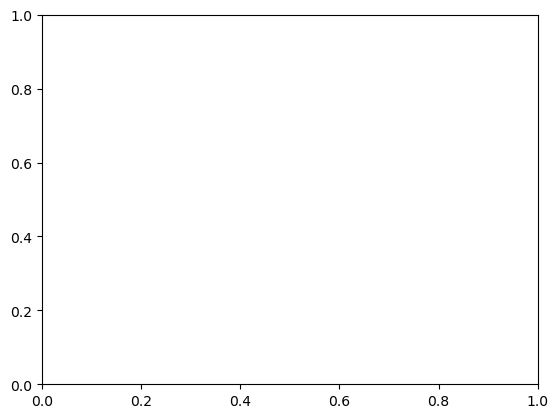

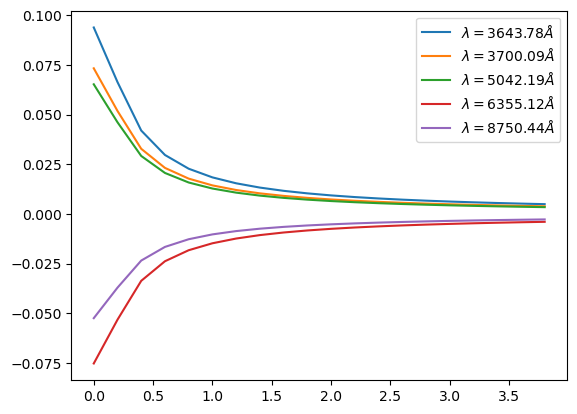

In [29]:
def gamma2snr2():
    nd = axis0[:].shape[0]
    delta = axis0[1]-axis0[0]
    drad = 0.475e15
    ndisk = int(2*drad/delta)
    factor=20
    norder = factor * 5
    
    # nexpand = int(factor*ndisk)
    flux = numpy.zeros(nd*factor)
    fig, ax = plt.subplots()
    fig2, ax2 = plt.subplots()  
    for index in [maxorder[0],idx3700,maxorder[-1],idx6355,idx8750]:
        flux[:]=0
        flux[:nd] = block0_values[index,:]
        # flux[:ndisk] = 1
        gamma = dft_polar(flux,norder=norder)
        gamma0 = gamma[0]
        gamma=gamma/gamma[0]
        gamma2 = gamma*gamma
        # ax.plot(numpy.arange(gamma2.shape[0])*2*numpy.pi/(nd*factor/ndisk),gamma2,label=r"$\lambda={:.2f}\AA$".format(lambdas[index]))

        fm = dgamma2dsi(flux, 1, numpy.arange(20), norder=norder)/gamma0**2
        # fm = dgamma2ds(flux, norder=norder)/gamma0**2
        # fm = numpy.zeros((2,2))
        # dg2ds1 = dgamma2ds1(flux, norder=norder)/gamma0**2
        # fm[0][0] = dgamma2ds(flux, norder=norder)/gamma0**2
        # fm= numpy.abs(fm)
        ax2.plot(numpy.arange(fm.shape[0])*2*numpy.pi/(nd*factor/ndisk),fm,label=r"$\lambda={:.2f}\AA$".format(lambdas[index]))
    
    # zeta = numpy.arange(0,nd,0.01)

    # dairy = (2*(2*jv(1,zeta)/zeta)*(jv(0,zeta)-jv(2,zeta)-2*jv(1,zeta)/zeta))
    # ax2.plot(zeta,numpy.abs(dairy),label='Airy',ls='dotted')
    # ax2.set_ylabel(r"$\text{SNR}_s$")
    # ax2.set_xlabel(r"$\zeta$")
    # ax2.set_xlim((0,10))
    # ax2.set_ylim((0,1))
    ax2.legend()
    # fig2.savefig('snr2.pdf')

gamma2snr2()